<a href="https://colab.research.google.com/github/HEMA1188/GANs/blob/main/AnimeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install jovian --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import jovian

In [3]:
pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:14<00:00, 28.6MB/s]


In [5]:
import os
DATA_DIR='./animefacedataset/'
print(os.listdir(DATA_DIR))

['images']


In [6]:
print(os.listdir(DATA_DIR+'/images')[:10])

['4586_2003.jpg', '33328_2011.jpg', '39653_2012.jpg', '49767_2015.jpg', '33106_2011.jpg', '16130_2006.jpg', '37229_2012.jpg', '8038_2004.jpg', '45129_2014.jpg', '40609_2013.jpg']


In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [8]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [9]:
train_ds=ImageFolder(DATA_DIR, transform=T.Compose([
                     T.Resize(image_size),
                     T.CenterCrop(image_size),
                     T.ToTensor(),
                     T.Normalize(*stats)]))
train_dl=DataLoader(train_ds, batch_size, shuffle=True,num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [12]:
def show_images(images, nmax=64):
  fig,ax =plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(d1,nmax=64):
  for images,_ in d1:
    show_images(images,nmax)
    break


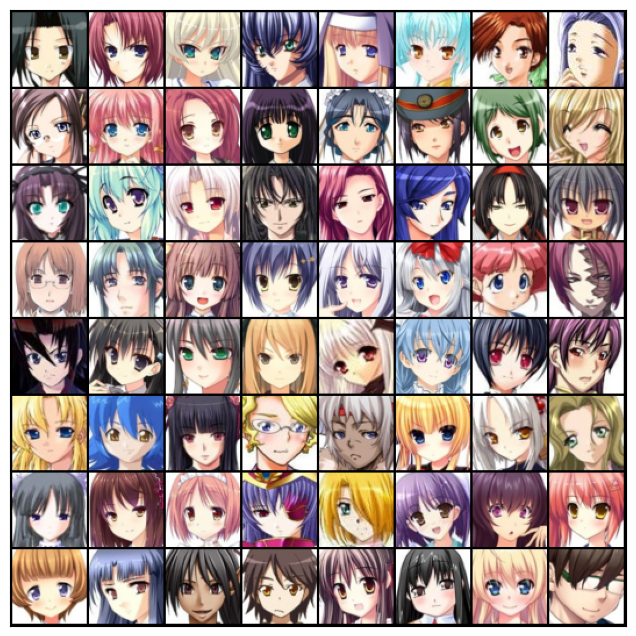

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)


In [15]:
device=get_default_device()
device

device(type='cuda')

In [16]:
train_dl=DeviceDataLoader(train_dl,device)

In [17]:
import torch.nn as nn

In [18]:
discriminator=nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(64),
              nn.LeakyReLU(0.2,inplace=True),
              nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.LeakyReLU(0.2,inplace=True),
              nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.LeakyReLU(0.2,inplace=True),
              nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.LeakyReLU(0.2,inplace=True),

              nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1, bias=False),
              nn.Flatten(),
              nn.Sigmoid()

)

In [19]:
discriminator=to_device(discriminator,device)

In [20]:
latent_size=128

In [21]:
generator=nn.Sequential(
              nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.ReLU(True),
              nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.ReLU(True),
              nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.ReLU(True),
              nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(64),
              nn.ReLU(True),

              nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
              nn.Tanh(),

)

torch.Size([128, 3, 32, 32])


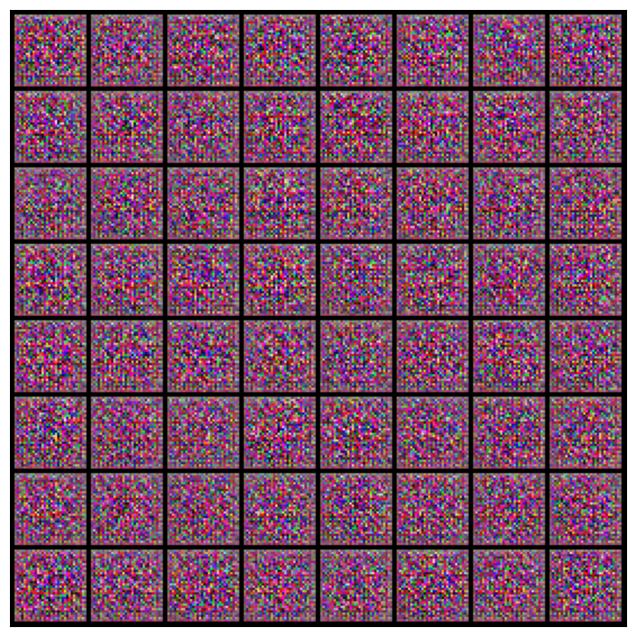

In [22]:
xb=torch.randn(batch_size,latent_size,1,1)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [23]:
generator=to_device(generator,device)

In [36]:
def train_discriminator(real_images,opt_d):
  opt_d.zero_grad()
  #pass real images to discriminator
  real_preds=discriminator(real_images)
  real_targets=torch.ones(real_images.size(0),1,device=device)
  real_loss=F.binary_cross_entropy(real_preds,real_targets)
  real_score=torch.mean(real_preds).item()

  #generate Fake Images

  latent=torch.randn(batch_size, latent_size, 1,1,device=device)
  fake_images=generator(latent)

  #Pass fake image to discriminator

  fake_targets=torch.zeros(fake_images.size(0), 1,device=device)
  fake_preds=discriminator(fake_images)
  fake_loss=F.binary_cross_entropy(fake_preds,fake_targets)
  fake_score=torch.mean(fake_preds).item()

  loss=real_loss+fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score





In [25]:
def train_generator(opt_g):
  opt_g.zero_grad()

  #generate Fake Images

  latent=torch.randn(batch_size, latent_size, 1,1,device=device)
  fake_images=generator(latent)

  #Try to Fool discriminator
  preds=discriminator(fake_images)
  targets=torch.ones(batch_size,1,device=device)
  loss= F.binary_cross_entropy(preds,targets)

  #update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()



In [26]:
from torchvision.utils import save_image



In [27]:
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [28]:
def save_samples(index,latent_tensors, show=True):
  fake_images=generator(latent_tensors)
  fake_fname='generted-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
  print('saving',fake_fname)

  if show:
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))


In [29]:
fixed_latent=torch.randn(64, latent_size,1,1,device=device)

saving generted-images-0000.png


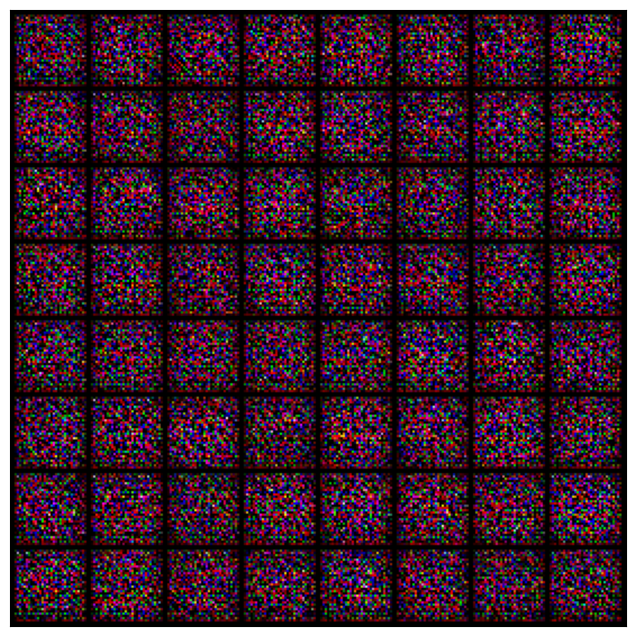

In [30]:
save_samples(0,fixed_latent)

In [31]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [42]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  # losses and scores

  losses_d=[]
  losses_g=[]
  real_scores=[]
  fake_scores=[]

  #create optimizers
  opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))

  opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images,_ in tqdm(train_dl):
      # Train Discriminator
      loss_d, real_score, fake_score= train_discriminator(real_images, opt_d)
      # Train Generator
      loss_g= train_generator(opt_g)

      # Record and Scores

      losses_g.append(loss_g)
      losses_d.append(loss_d)
      real_scores.append(real_score)
      fake_scores.append(fake_score)

      # log lossess and score (last batch)
      print("Epoch [{}/{}],loss_g: {:.4f},loss_d: {:.4f},real_score:{:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

      # save generator images
      save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores



In [46]:
import gc
gc.collect()

4343

In [43]:
lr=0.0002
epochs=10

In [44]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [47]:
history=fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ValueError: ignored

In [ ]:
losses_g,losses_d,real_scores,fake_scores=history

In [ ]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])

In [ ]:
torch.save(generator.state_dict(),'G.Pth')
torch.save(discriminator.state_dict(),'D.Pth')